# Description

Measurements of time that model takes for training and prediction. Also measurements of time that is consumed for cleaning datasets.

In [ ]:
%%capture
!pip install git+https://github.com/SergeiSah/Product_classification.git

In [6]:
import gpustat
import torch
import pandas as pd
from product_classificator import Classificator, load
from product_classificator.training import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [7]:
def plot_log_info(log):
    gpu_stats = gpustat.GPUStatCollection.new_query()
    
    for gpu in gpu_stats.gpus:
        print(f"GPU {gpu.index}: {gpu.name}")
    
    desc = log.describe().drop('count')
    desc.loc['sum'] = desc.sum()
    display(desc.iloc[:, :-2].style.background_gradient(axis=1))
    display(desc.iloc[:, -2:])
    
    log[log < log.quantile(0.99)].iloc[:, :-2].plot(kind='hist', bins=100)
    plt.title('Time measurements')
    plt.xlabel('Time (sec.)');

In [8]:
test = pd.read_parquet(
    '../input/wbtech-horizontal-ml-texts/wb_school_test.parquet'
).dropna(subset=['description'])

images = test.nm.apply(lambda x: str(x) + '.jpg').values
texts = test.description.values

device = 'cuda' if torch.cuda.is_available() else 'cpu'
load('ruclip-vit-base-patch16-384')
clf = Classificator(device=device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:669: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.4.0 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Text preprocessing

Preprocessing includes:
- loading of the train and test .parquet files
- cleaning datasets from records with empty description
- extraction of characteristics in train dataset
- cleanening: removing digits, punctuations, stopwords (except 'не' and 'для'), convertation to lower case

In [6]:
%%time
log_preprocessing = test_preprocessing_time(
    '../input/wbtech-horizontal-ml-texts/',
    iterations_num=4
)

Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/98660 [00:00<?, ?it/s]

  0%|          | 0/98660 [00:00<?, ?it/s]

  0%|          | 0/29653 [00:00<?, ?it/s]

Iterations:  25%|██▌       | 1/4 [08:40<26:00, 520.29s/it]

  0%|          | 0/98660 [00:00<?, ?it/s]

  0%|          | 0/98660 [00:00<?, ?it/s]

  0%|          | 0/29653 [00:00<?, ?it/s]

Iterations:  50%|█████     | 2/4 [17:15<17:14, 517.28s/it]

  0%|          | 0/98660 [00:00<?, ?it/s]

  0%|          | 0/98660 [00:00<?, ?it/s]

  0%|          | 0/29653 [00:00<?, ?it/s]

Iterations:  75%|███████▌  | 3/4 [26:01<08:41, 521.30s/it]

  0%|          | 0/98660 [00:00<?, ?it/s]

  0%|          | 0/98660 [00:00<?, ?it/s]

  0%|          | 0/29653 [00:00<?, ?it/s]

Iterations: 100%|██████████| 4/4 [34:33<00:00, 518.34s/it]

CPU times: user 34min 24s, sys: 23.6 s, total: 34min 47s
Wall time: 34min 33s


In [7]:
log_preprocessing.describe()

,loading_dfs,cleaning_dfs,processing_chars,cleaning_train_desc,cleaning_test_desc
count,4.000000,4.000000,4.000000,4.000000,4.000000
mean,3.184043,5.297181,71.676512,337.564626,100.606686
std,0.907126,0.335929,1.756650,4.515859,1.147970
min,2.593937,4.915953,70.693718,333.059097,99.665226
25%,2.744851,5.134179,70.802037,334.168590,99.866168
50%,2.802785,5.273804,70.851630,337.286604,100.269100
75%,3.241977,5.436806,71.726105,340.682640,101.009618
max,4.536662,5.725164,74.309068,342.626200,102.223319


# Training

Only on test dataset.

In [6]:
params = {
    'clf': clf,
    'image_names': images,
    'texts': texts,
    'characteristics': ['category', 'sub_category', 'isadult'],
    'batch_size': 1,
    'path_to_images': '../input/wbtech-horizontal-ml-images/',
    'optimizer': torch.optim.Adam(
        clf.clip_predictor.clip_model.parameters(), 
        lr=5e-5, eps=1e-6, weight_decay=0.2),
    'loss_img': torch.nn.CrossEntropyLoss(),
    'loss_txt': torch.nn.CrossEntropyLoss(),
    'warming_up_batches_num': 5
}

In [7]:
test.shape

(29928, 8)

## One sample

In [8]:
%%time
log_training_smpl = test_ruclip_training_time(**params)

Batches: 100%|██████████| 29928/29928 [34:34<00:00, 14.43it/s]

CPU times: user 36min 47s, sys: 16.3 s, total: 37min 4s
Wall time: 34min 36s


GPU 0: Tesla P100-PCIE-16GB


,loading_images,image_processing,text_processing,calc_image_latents,calc_text_latents,loss_calc,loss_backprop,optimizer_step,saving_embeddings
mean,0.018595,0.009206,0.000505,0.006999,0.021345,0.000511,0.003039,0.001121,0.000164
std,0.003986,0.000613,0.000172,0.000553,0.000532,0.000513,0.001252,0.000556,0.000017
min,0.007500,0.005323,0.000177,0.006364,0.011628,0.000433,0.002718,0.001001,0.000124
25%,0.016175,0.008905,0.000388,0.006717,0.021212,0.000481,0.002902,0.001068,0.000155
50%,0.017614,0.009077,0.000471,0.006864,0.021447,0.000497,0.002974,0.001091,0.000161
75%,0.020111,0.009317,0.000595,0.007098,0.021618,0.000519,0.003060,0.001138,0.000168
max,0.147639,0.023661,0.001885,0.016557,0.024041,0.088799,0.213098,0.095690,0.000649
sum,0.231620,0.066102,0.004192,0.051151,0.121823,0.091752,0.229043,0.101666,0.001438


,cols_sum,sum_batch_time
mean,0.061484,0.068322
std,0.004830,0.004857
min,0.048641,0.055679
25%,0.058835,0.065661
50%,0.060546,0.067397
75%,0.063078,0.069944
max,0.470985,0.476939
sum,0.768399,0.808799


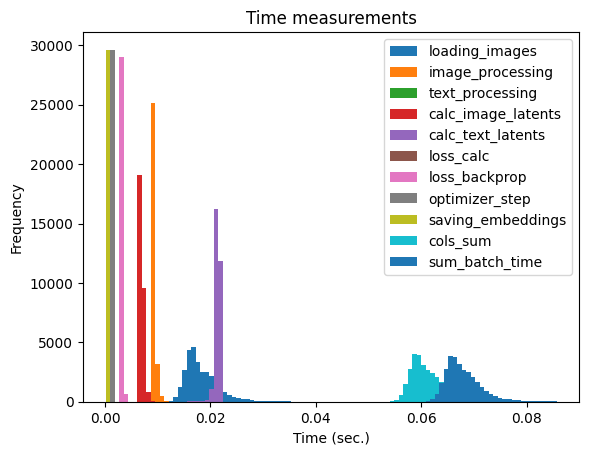

In [16]:
plot_log_info(log_training_smpl)

## Batch 64

In [7]:
params['batch_size'] = 64
params['warming_up_batches_num'] = 0

In [13]:
%%time
log_training_batch = test_ruclip_training_time(**params)

Batches: 468it [21:54,  2.81s/it]                         

CPU times: user 25min 22s, sys: 31.7 s, total: 25min 54s
Wall time: 21min 54s


GPU 0: Tesla P100-PCIE-16GB


,loading_images,image_processing,text_processing,calc_image_latents,calc_text_latents,loss_calc,loss_backprop,optimizer_step,saving_embeddings
mean,0.581005,0.626940,0.017005,0.007652,1.307838,0.000695,0.003645,0.001292,0.000800
std,0.030556,0.033584,0.001500,0.000525,0.023417,0.000070,0.000438,0.000205,0.000065
min,0.338172,0.365188,0.010446,0.007247,0.808997,0.000623,0.003309,0.001175,0.000650
25%,0.560955,0.613011,0.016108,0.007429,1.307996,0.000661,0.003423,0.001213,0.000755
50%,0.578482,0.619348,0.016833,0.007515,1.309639,0.000675,0.003504,0.001231,0.000803
75%,0.598963,0.629716,0.017620,0.007674,1.310975,0.000697,0.003650,0.001273,0.000840
max,0.725495,0.837859,0.027878,0.012170,1.316041,0.001241,0.007357,0.002946,0.001155
sum,3.413628,3.725646,0.107390,0.050211,7.384904,0.004662,0.025326,0.009335,0.005069


,cols_sum,sum_batch_time
mean,2.546873,2.806311
std,0.066506,0.069622
min,1.536738,1.702182
25%,2.520971,2.781015
50%,2.540783,2.799249
75%,2.566437,2.824932
max,2.825675,3.086687
sum,14.603983,16.069998


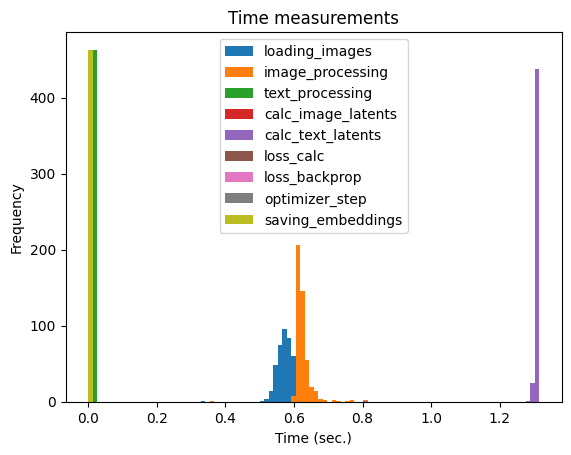

In [17]:
plot_log_info(log_training_batch)

# Inference

## Batch 64

In [21]:
params = {
    'clf': clf,
    'image_names': images,
    'texts': texts,
    'characteristics': ['category', 'sub_category', 'isadult'],
    'batch_size': 64,
    'path_to_images': '../input/wbtech-horizontal-ml-images/',
}

In [ ]:
%%time
log_inference = test_classifier_inference_time(**params)

GPU 0: Tesla P100-PCIE-16GB


,loading_images,image_processing,text_processing,calc_image_latents,calc_text_latents,predictions
mean,0.601669,0.584175,0.017131,0.031984,1.695732,0.019890
std,0.031900,0.030908,0.001836,0.000869,0.031558,0.024141
min,0.431545,0.345230,0.010891,0.024220,1.075067,0.007046
25%,0.583167,0.565942,0.016107,0.031599,1.689654,0.011695
50%,0.601929,0.581136,0.016884,0.031830,1.694749,0.013099
75%,0.620000,0.591388,0.017692,0.032166,1.701736,0.013899
max,0.710122,0.832009,0.029312,0.040060,1.775062,0.146643
sum,3.580331,3.530787,0.109853,0.192728,9.663559,0.236412


,cols_sum,sum_batch_time
mean,2.950581,2.953192
std,0.073043,0.073072
min,1.899760,1.902325
25%,2.918037,2.920567
50%,2.945812,2.948411
75%,2.974920,2.977529
max,3.277855,3.280738
sum,17.040008,17.055834


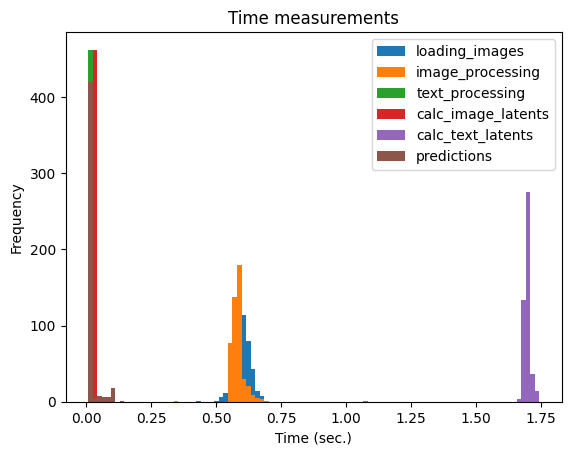

In [23]:
plot_log_info(log_inference)

## One sample

In [9]:
params = {
    'clf': clf,
    'image_names': images[:10000],
    'texts': texts[:10000],
    'characteristics': ['category', 'sub_category', 'isadult'],
    'batch_size': 1,
    'path_to_images': '../input/wbtech-horizontal-ml-images/',
}

In [10]:
%%time
log_inference = test_classifier_inference_time(**params)

100%|██████████| 10000/10000 [17:30<00:00,  9.52it/s]

CPU times: user 40min 23s, sys: 26min 21s, total: 1h 6min 45s
Wall time: 17min 32s


GPU 0: Tesla P100-PCIE-16GB


,loading_images,image_processing,text_processing,calc_image_latents,calc_text_latents,predictions
mean,0.024562,0.022732,0.000697,0.014608,0.032382,0.004760
std,0.011120,0.016927,0.000478,0.005233,0.004718,0.010610
min,0.008946,0.007711,0.000152,0.009062,0.009721,0.002162
25%,0.017431,0.017483,0.000457,0.010724,0.028470,0.002784
50%,0.022337,0.018012,0.000601,0.011550,0.035103,0.002965
75%,0.027184,0.018846,0.000820,0.019129,0.035967,0.003221
max,0.134028,0.119507,0.011420,0.073077,0.061491,0.108290
sum,0.245607,0.221217,0.014626,0.143382,0.207852,0.134792


,cols_sum,sum_batch_time
mean,0.099742,0.102287
std,0.024201,0.024367
min,0.066765,0.068608
25%,0.086435,0.088774
50%,0.092512,0.095101
75%,0.100058,0.102832
max,0.265831,0.267928
sum,0.735544,0.749897


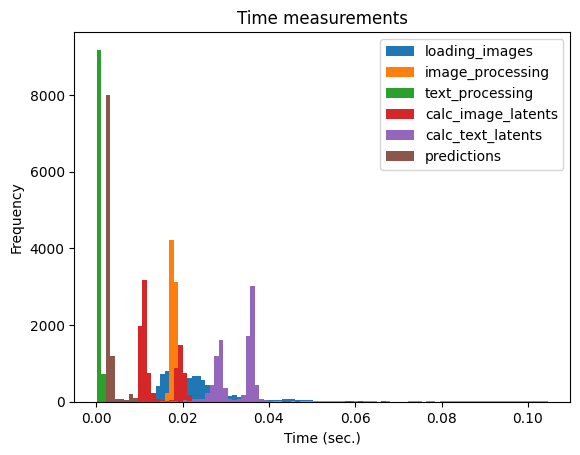

In [11]:
plot_log_info(log_inference)

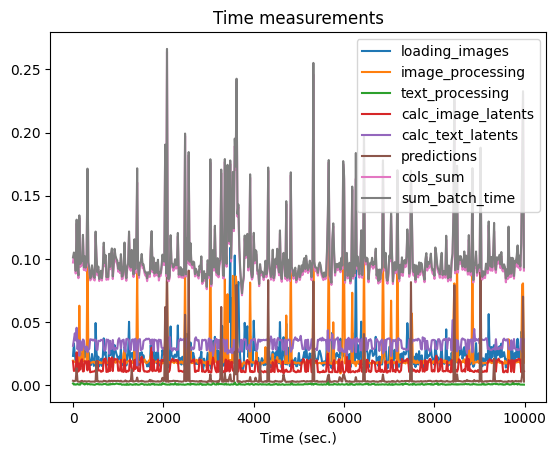

In [17]:
log_inference[log_inference.index % 20 == 0].plot()
plt.title('Time measurements')
plt.xlabel('Time (sec.)');